In [1]:
# !python -m pip install ipywidgets

In [2]:
# !python -m pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu118

In [3]:
# !python -m pip install "unsloth[cu118-ampere-torch230] @ git+https://github.com/unslothai/unsloth.git" --no-deps

In [4]:
# !python -m pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes

In [5]:
# !python -m pip install matplotlib pandas

In [6]:
# !python -m pip install transformers

In [7]:
# !python -m pip install -U xformers --index-url https://download.pytorch.org/whl/cu118

In [8]:
# !python -m pip install rich datasets

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import json
import os
from tqdm import tqdm, trange

In [10]:
from unsloth import FastLanguageModel
from llama_tokenizer_fix import CustomLlama3Tokenizer

model, _ = FastLanguageModel.from_pretrained(
    model_name="unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    dtype=None,        # None for auto detect
    load_in_4bit=True,
) # about 6GB in size

tokenizer = CustomLlama3Tokenizer("unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.0.
   \\   /|    GPU: NVIDIA RTX A6000. Max memory: 47.536 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.0+cu118. CUDA = 8.6. CUDA Toolkit = 11.8.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.27.post2+cu118. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


In [11]:
load_data_length = 150
feature_num = 2
ignore_cache = True
ignore_summaries = False
# ignore_cache = False

In [12]:
# len(list(Path("coauthor").glob("*.jsonl")))

In [13]:
import json
from pathlib import Path

folder = Path("coauthor")

def load_coauthor_raw(length=-1):
    print('Loading data...')
    data = []

    for i, file in enumerate(folder.glob("*.jsonl")):
        if length != -1 and i >= length:
            break
        text = file.read_text().splitlines()
        article = [json.loads(line) for line in text]
        data.append(article)
    return data

def apply_ops(doc, mask, ops, source):
    new_doc = ''
    new_mask = ''

    for i, op in enumerate(ops):
        if 'retain' in op:
            num_char = op['retain']
            new_doc += doc[:num_char]
            new_mask += mask[:num_char]
            doc = doc[num_char:]
            mask = mask[num_char:]

        elif 'insert' in op:
            text = op['insert']
            if isinstance(text, dict):
                if 'image' in text:
                    print('Skipping invalid object insertion (image)')
                else:
                    print('Ignore invalid insertions:', op)
                continue

            new_doc += text
            if source == 'api':
                new_mask += 'A' * len(text)
            else:
                new_mask += 'U' * len(text)

        elif 'delete' in op:
            num_char = op['delete']

            if doc:
                doc = doc[num_char:]
                mask = mask[num_char:]
            else:
                new_doc = new_doc[:-num_char]
                new_mask = new_mask[:-num_char]

        else:
            print('Ignore invalid operation:', op)

    return new_doc + doc, new_mask + mask


def extract_text_and_mask(events):
    prompt = events[0]['currentDoc'].strip()
    text = prompt
    mask = 'P' * len(prompt)

    for event in events:
        if 'ops' not in event['textDelta']:
            continue
        ops = event['textDelta']['ops']
        source = event['eventSource']
        text, mask = apply_ops(text, mask, ops, source)

    return text, mask

In [14]:
def summarize(text):
    messages = [
        {"role": "system", "content": "Your job is to summarize articles. Only summarize articles. Do not do anything else."},
        {"role": "user", "content": f'Summarize the following article in a short sentence: {text}'},
    ]
    prompt = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
    )
    with torch.no_grad():
        # inference_model = model.for_inference()
        output = FastLanguageModel.for_inference(model).generate(input_ids=prompt, max_new_tokens=100)
    output = output[0][prompt.shape[1]:]
    output = tokenizer.decode(output, skip_special_tokens=True)
    return output

def summarize_all(texts):
    print("Summarizing...")
    summaries = []
    for text in tqdm(texts):
        summary = summarize(text)
        summaries.append(summary)
    return summaries

In [15]:
import torch.nn.functional as F

def format_prompt(topic, article):
    messages = [
        {"role": "system", "content": "You are a helpful assistant that writes the paragraphs for the user"},
        {"role": "user", "content": f'Write an article for me for the following topic: """{topic}"""'},
        {"role": "assistant", "content": article},
    ]
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
    )[:-10]

    return prompt

In [16]:
# text1 = format_prompt(" Hey1", " asf1")
# text2 = format_prompt(" gadjlkasjf", "L in the chat")
# tokens1 = tokenizer(text1, return_tensors="pt")['input_ids'][0]
# tokens2 = tokenizer(text2, return_tensors="pt")['input_ids'][0]

# print(tokens1, tokens2)


# # find the LAST occurence of the token id 271
# appearances1 = (tokens1 == 271).nonzero(as_tuple=True)[0][-1]
# appearances2 = (tokens2 == 271).nonzero(as_tuple=True)[0][-1]

# unformatted_tokens1 = tokens1[appearances1+1:]
# unformatted_tokens2 = tokens2[appearances2+1:]

# print(unformatted_tokens1, unformatted_tokens2)

# unformatted_text1 = tokenizer.decode(unformatted_tokens1)
# unformatted_text2 = tokenizer.decode(unformatted_tokens2)

# print(unformatted_text1, unformatted_text2)

In [17]:
def get_token_labels(summary, text, label, max_length):
    formatted_text = format_prompt(summary, text)
    output = tokenizer(formatted_text, return_tensors="pt", return_offsets_mapping=True, max_length=max_length, truncation=True)
    input_ids = output.input_ids
    offset_mapping = output.offset_mapping

    # find the LAST occurence of the token id 271
    format_end_token_index = (input_ids[0] == 271).nonzero(as_tuple=True)[0][-1] + 1
    text_mappings = offset_mapping[format_end_token_index:]

    format_end_text_index = text_mappings[0][0]

    text_mappings = [(start - format_end_text_index, end - format_end_text_index) for start, end in text_mappings]

    token_labels = np.zeros_like(input_ids[0][format_end_token_index:], dtype=np.float32)

    for i, (start, end) in enumerate(text_mappings):
        word_label = label[start:end]
        length = max(1, len(word_label))
        ai_percentage = word_label.count('A') / length
        token_labels[i] = ai_percentage

    return token_labels, input_ids, format_end_token_index

def get_features(input_ids, format_end_token_index):
    input_ids = input_ids.to(model.device)

    with torch.no_grad():
        output = model(input_ids, return_dict=True)

    input_ids = input_ids[0][1:]
    logits = output.logits[0]
    probs = torch.softmax(logits, dim=-1, dtype=torch.float32)
    eps = 1e-10
    probs = torch.clamp(probs, eps, 1)[:-1]
    bits = -torch.log2(probs)

    indices = torch.arange(0, input_ids.size(0)).to(model.device)
    token_bits = bits[indices, input_ids].detach().cpu().numpy()
    entropy = torch.sum(probs * bits, dim=-1).detach().cpu().numpy()

    features = np.stack([
        token_bits,
        entropy,
    ], axis=-1)
    features = features[format_end_token_index:]
    return features

def get_features_and_labels(summary, text, labels, max_length):
    labels, input_ids, format_end_token_index = get_token_labels(summary, text, labels, max_length)
    features = get_features(input_ids, format_end_token_index)

    # we dont need the last token
    labels = labels[:-1]
    return features, labels

In [18]:
def process_data(summaries, data, max_size=1200):
    print("Processing data...")
    data_size = len(data)

    features = np.zeros((data_size, max_size, feature_num))
    labels = np.zeros((data_size, max_size, 1))
    masks = np.zeros((data_size, max_size, 1))

    for i, (summary, (text, raw_label)) in tqdm(enumerate(zip(summaries, data)), total=data_size):
        # bit, mask, entropy, similarity = get_tokens_and_masks(text, mask)
        # print(text, mask, max_size)
        feature, label = get_features_and_labels(summary, text, raw_label, max_size)
        size = feature.shape[0]

        features[i, :size] = feature
        labels[i, :size, 0] = label
        masks[i, :size, 0] = 1

    return features, labels, masks

In [19]:
name = "Llama-3-8b-Instruct-bnb-4bit"

In [20]:
if not os.path.exists(f'cache/{name}'):
    os.mkdir(f'cache/{name}')

In [21]:
def store(features, labels, masks, data_name):
    data = np.concatenate([features, labels, masks], axis=-1)
    np.save(f'cache/{name}/{data_name}.npy', data)

def store_summaries(summaries, data_name):
    if not os.path.exists(f'cache/{name}/summaries'):
        os.mkdir(f'cache/{name}/summaries')
    with open(f'cache/{name}/summaries/{data_name}.json', 'w') as file:
        json.dump(summaries, file)

def load(data_name):
    data = np.load(f'cache/{name}/{data_name}.npy')
    features = data[:, :, :-2]
    labels = data[:, :, -2:-1]
    masks = data[:, :, -1:]
    print(features.shape)
    print(labels.shape)
    print(masks.shape)

    return features, labels, masks

def load_summaries(data_name):
    with open(f'cache/{name}/summaries/{data_name}.json', 'r') as file:
        summaries = json.load(file)
    return summaries


def exists(data_name):
    return Path(f'cache/{name}/{data_name}.npy').exists()

In [22]:
load_data_length

150

In [23]:
def constructing_data(raw_data):
    print('Constructing data...')
    data = []
    for raw in tqdm(raw_data):
        text, mask = extract_text_and_mask(raw)
        data.append((text, mask))
    return data

In [24]:
if exists('coauthor') and not ignore_cache:
    cf, cl, cm = load('coauthor')
else:
    coauthor_raw = load_coauthor_raw(load_data_length * 4)
    coauthor_data = list(map(extract_text_and_mask, coauthor_raw))

    # summaries = summarize_all([text for text, _ in coauthor_data])
    # store_summaries(summaries, 'coauthor')

    summaries = load_summaries('coauthor')
    cf, cl, cm = process_data(summaries, coauthor_data)
    store(cf, cl, cm, 'coauthor')

Loading data...
Processing data...


100%|██████████| 600/600 [01:41<00:00,  5.90it/s]


In [25]:
if exists('human') and not ignore_cache:
    hf, hl, hm = load('human')
else:
    with open("dataset_creation/human_dataset.json", "r") as f:
        human_data = json.load(f)
        human_data = list(map(lambda x: x["article"], human_data))

    human_data = human_data[:int(load_data_length)]

    # summaries = summarize_all(human_data)
    # store_summaries(summaries, 'human')

    summaries = load_summaries('human')
    human_data = list(map(lambda x: (x, "U" * len(x)), human_data))

    hf, hl, hm = process_data(summaries, human_data)
    store(hf, hl, hm, 'human')

Processing data...


100%|██████████| 150/150 [00:28<00:00,  5.31it/s]


In [26]:
if exists('generation') and not ignore_cache:
    gf, gl, gm = load('generation')
else:
    with open("dataset_creation/generation_dataset.json", "r") as f:
        generation_data = json.load(f)
        generation_data = list(map(lambda x: x["article"], generation_data))

    generation_data = generation_data[:load_data_length]

    # summaries = summarize_all(generation_data)
    # store_summaries(summaries, 'generation')

    summaries = load_summaries('generation')
    generation_data = list(map(lambda x: (x, "A" * len(x)), generation_data))

    gf, gl, gm = process_data(summaries, generation_data)
    store(gf, gl, gm, 'generation')

Processing data...


100%|██████████| 150/150 [00:24<00:00,  6.02it/s]


In [27]:
if exists('refinement') and not ignore_cache:
    rf, rl, rm = load('refinement')
else:
    with open("dataset_creation/refinement_dataset.json", "r") as f:
        refinement_data = json.load(f)
        refinement_data = list(map(lambda x: x["article"], refinement_data))

    refinement_data = refinement_data[:int(load_data_length)]

    # summaries = summarize_all(refinement_data)
    # store_summaries(summaries, 'refinement')

    summaries = load_summaries('refinement')
    refinement_data = list(map(lambda x: (x, "A" * len(x)), refinement_data))

    rf, rl, rm = process_data(summaries, refinement_data)
    store(rf, rl, rm, 'refinement')

Processing data...


100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


In [28]:
def create_mask(human_mask_length, total_length):
    return "U" * human_mask_length + "A" * (total_length - human_mask_length)

def preprocess(data):
    return data['article'], create_mask(data['mask'], len(data['article']))

if exists('completion') and not ignore_cache:
    cpf, cpl, cpm = load('completion')
else:
    with open("dataset_creation/completion_dataset.json", "r") as f:
        completion_data = json.load(f)
        completion_data = list(map(preprocess, completion_data))
    completion_data = completion_data[:int(load_data_length)]

    # summaries = summarize_all([text for text, _ in completion_data])
    # store_summaries(summaries, 'completion')

    summaries = load_summaries('completion')
    cpf, cpl, cpm = process_data(summaries, completion_data)
    store(cpf, cpl, cpm, 'completion')

Processing data...


100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


In [29]:
# gf = gf[:10]
# gl = gl[:10]
# gm = gm[:10]

In [30]:
# features = np.concatenate([cf, hf, gf, cpf])
# labels = np.concatenate([cl, hl, gl, cpl])
# masks = np.concatenate([cm, hm, gm, cpm])

# features = np.concatenate([cf, gf])
# labels = np.concatenate([cl, gl])
# masks = np.concatenate([cm, gm])

In [31]:
# empty_entry = (np.sum(masks, axis=1) == 0).flatten()
# features = features[~empty_entry]
# labels = labels[~empty_entry]
# masks = masks[~empty_entry]

# print(f"Removed empty entries: {empty_entry.sum()}")

In [32]:
# index = 512

# size = int(np.sum(masks[index, :, 0]))
# # plt.scatter(x=range(size), y=features[index, :, 0][:size], c=labels[index, :, 0][:size], cmap='coolwarm', s=1)
# # print(coauthor_data[index][0])

# easy_indices = y=features[index, :, 0][:size] < 5
# text = format_prompt(coauthor_data[index][0])
# tokens = tokenizer(text, return_tensors="pt", return_offsets_mapping=True, max_length=1200, truncation=True)
# input_ids = tokens.input_ids
# offset_mapping = tokens.offset_mapping[0].detach().cpu().numpy()

# easy_words = [text[offset_mapping[i][0]:offset_mapping[i][1]] for i in range(size) if easy_indices[i]]
# print(easy_words)

In [33]:
def convolve_with_padding_same_size(signal, kernel):
    kernel_size = len(kernel)
    padded_signal = np.pad(signal, pad_width=(kernel_size//2, kernel_size//2), mode='reflect')
    convolved = np.convolve(padded_signal, kernel, mode='same')
    if kernel_size % 2 == 0:
        convolved = convolved[kernel_size//2:-kernel_size//2]
    else:
        convolved = convolved[kernel_size//2:-(kernel_size//2)-1]

    return convolved

def avg_pool(data, kernel_size):
    new_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        chunk = data[max(0, i-kernel_size//2):i+kernel_size//2]
        new_data[i] = np.mean(chunk)
    return new_data

def smooth_1d(data, mask, kernel):
    data = data[mask == 1]
    data = convolve_with_padding_same_size(data, kernel)
    # data = avg_pool(data, kernel.shape[0])
    return data

def smooth(data, mask, kernel):
    new_data = np.zeros_like(data)
    # print(data.shape)
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            smoothed_data = smooth_1d(data[i, :, j], mask[i, :, 0], kernel)
            new_data[i, :smoothed_data.shape[0], j] = smoothed_data
    return new_data

In [34]:
# factor = 200

# f = smooth(cf, cm, np.ones(factor) / factor)

# i = 15

# plot1 = cf[i, :, 0][cm[i, :, 0] == 1]
# plot2 = f[i, :, 0][cm[i, :, 0] == 1]

# plt.plot(plot1)
# plt.plot(plot2)
# plt.show()

In [35]:
def boxcar_kernel(length):
    return np.ones(length) / length

def boxcar_left_kernel(length):
    kernel = np.ones(length) / length
    if length % 2 == 0:
        kernel[length // 2:] = 0
    else:
        kernel[length // 2 + 1:] = 0
    return kernel

def boxcar_right_kernel(length):
    kernel = np.ones(length) / length
    kernel[:length // 2] = 0
    return kernel

def gaussian_kernel(length, sigma=1):
    x = np.linspace(-length // 2, length // 2, length)
    return np.exp(-x**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def triangular_kernel(length):
    return (1 - np.abs(np.linspace(-1, 1, length)))

def epanechnikov_kernel(length):
    x = np.linspace(-1, 1, length)
    return np.where(np.abs(x) <= 1, 0.75 * (1 - x**2), 0)

def hamming_kernel(length):
    return np.hamming(length)

def hanning_kernel(length):
    return np.hanning(length)

def blackman_kernel(length):
    return np.blackman(length)

def kaiser_kernel(length, beta=0.5):
    return np.kaiser(length, beta)

def cosine_kernel(length):
    return np.cos(np.linspace(-np.pi/2, np.pi/2, length))

def sinc_kernel(length):
    x = np.linspace(-length // 2, length // 2, length)
    return np.where(x == 0, 1, np.sin(x) / x)

def bartlett_kernel(length):
    return np.bartlett(length)

def welch_kernel(length):
    n = np.arange(0, length)
    return 1 - ((n - (length - 1) / 2) / ((length - 1) / 2))**2

def normalize(kernel):
    return kernel / np.sum(kernel)

kernels = {
    'boxcar': boxcar_kernel,
    'boxcar_left': boxcar_left_kernel,
    'boxcar_right': boxcar_right_kernel,
    'gaussian': gaussian_kernel,
    'triangular': triangular_kernel,
    'epanechnikov': epanechnikov_kernel,
    'hamming': hamming_kernel,
    'hanning': hanning_kernel,
    'blackman': blackman_kernel,
    'kaiser': kaiser_kernel,
    'cosine': cosine_kernel,
    'sinc': sinc_kernel,
    'bartlett': bartlett_kernel,
    'welch': welch_kernel,
}

In [36]:
# # simple 3d plot with plotly
# import plotly.graph_objects as go

# #entropy, similarity, bits, stdev
# def display_3d(features, labels, masks, kernel, display_size, smooth_label=False):
#     f = smooth(features, masks, kernel)
#     f = f[masks[:, :, 0] == 1]

#     if smooth_label:
#         l = smooth(labels, masks, kernel)[masks == 1]
#     else:
#         l = labels[masks == 1]

#     if display_size > f.shape[0]:
#         display_size = f.shape[0]
#     indices = np.random.choice(f.shape[0], display_size, replace=False)
#     f = f[indices]
#     l = l[indices]

#     x = f[:, 3]
#     y = f[:, 1]
#     z = f[:, 2]

#     go.Figure(data=[go.Scatter3d(
#         x=x,
#         y=y,
#         z=z,
#         mode='markers',
#         marker=dict(
#             size=1,
#             color=l,                # set color to an array/list of desired values
#             colorscale='Viridis',   # choose a colorscale
#             opacity=0.8
#         ),
#     )]).show()


# kernel_size = 20
# kernel = kernels['triangular'](kernel_size)

# display_3d(features, labels, masks, kernel, 100000, smooth_label=True)

In [37]:
def get_data(features, masks, labels, smooth_kernel, data_size=10000, indices=None):
    smooth_kernel = normalize(smooth_kernel)
    smooth_features = smooth(features, masks, smooth_kernel)

    X = smooth_features[masks[:, :, 0] == 1]
    Y = labels[masks == 1]

    if data_size > X.shape[0]:
        data_size = X.shape[0]
    # randomly select from the data
    if indices is None:
        indices = np.random.choice(X.shape[0], data_size, replace=False)
    X = X[indices]
    Y = Y[indices]

    Y = Y > 0.5

    return X, Y, indices

In [38]:
# X, Y, _ = get_data(features, masks, labels, kernels['boxcar'](20))

# entropy = X[:, 0]
# bits = X[:, 1]

# plt.scatter(entropy, bits, c=Y, s=1)

Hybrid-Human: 40000, Hybrid-AI: 40000
Human: 40000
AI: 40000
AI with human help: 25063
Completion AI: 26970, Completion Human: 30528


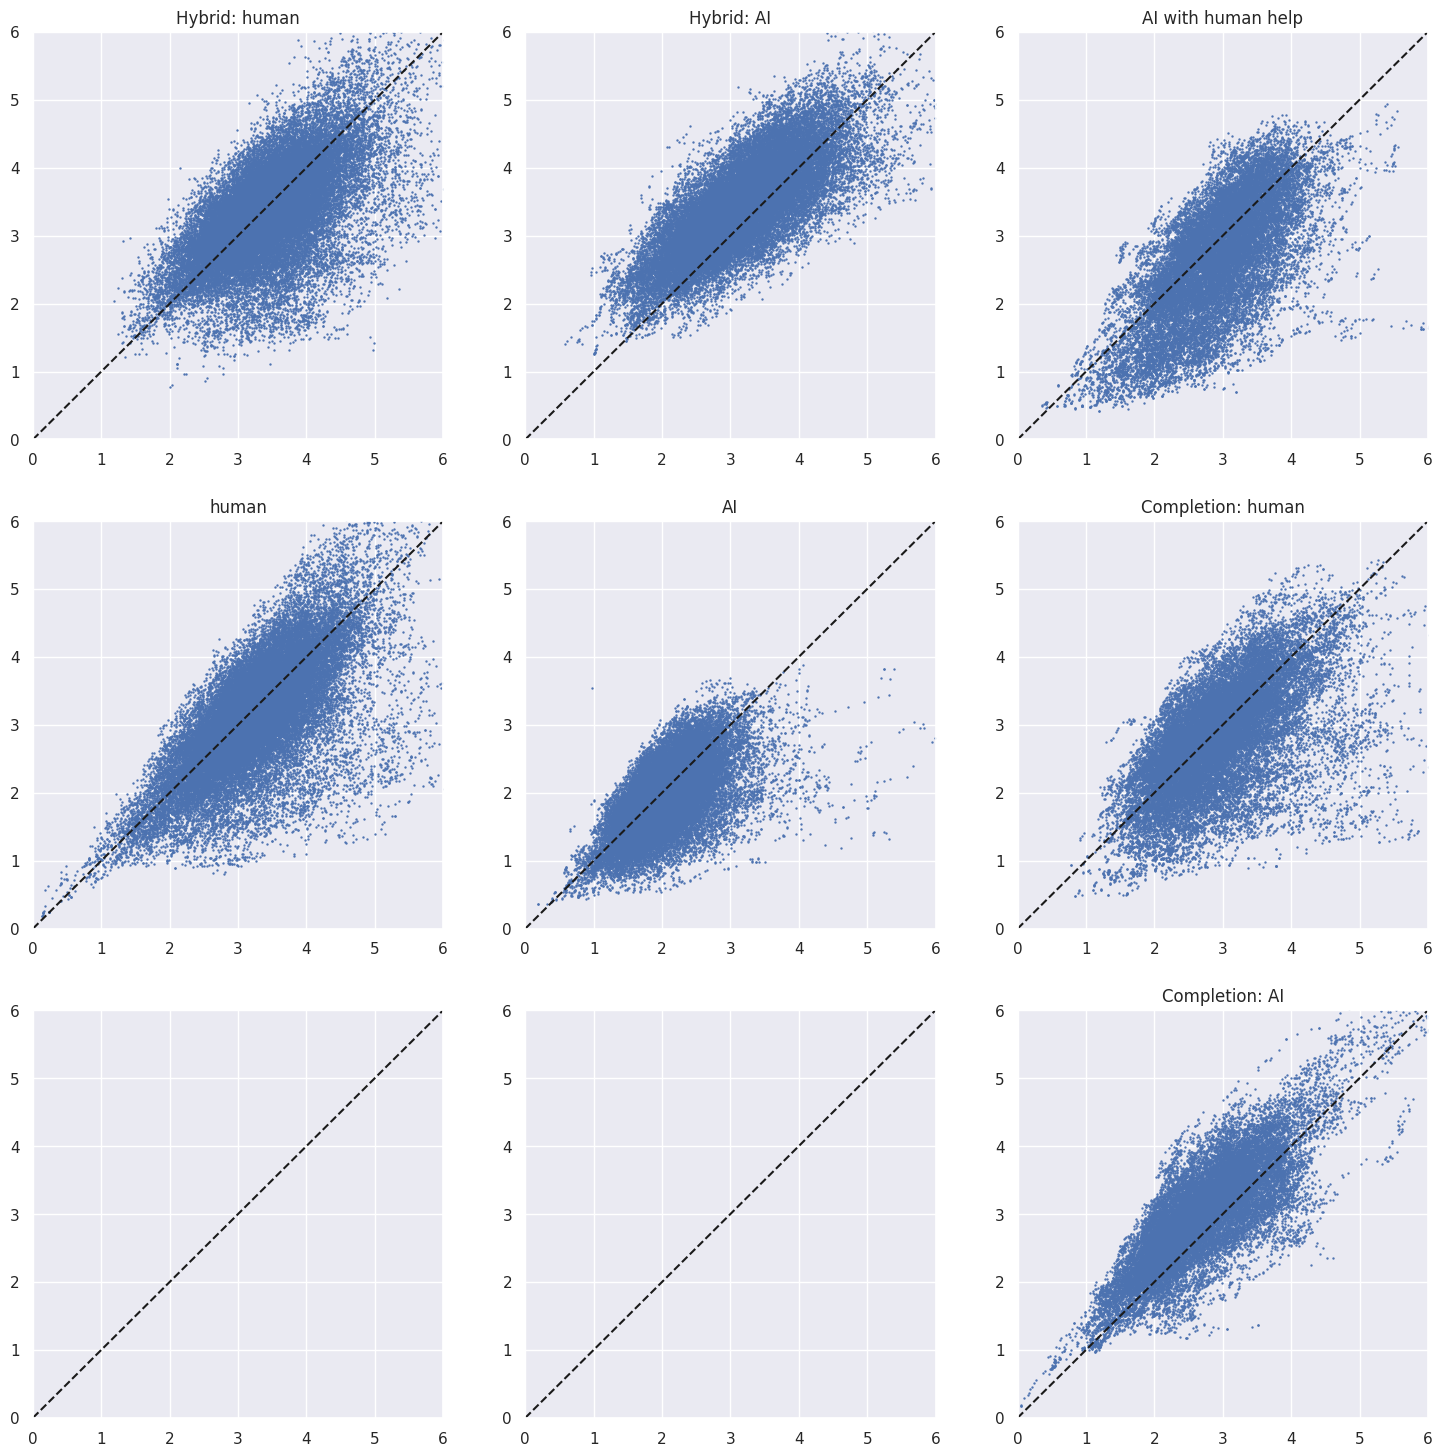

In [39]:
import seaborn as sns
sns.set_theme()

smoothing_kernel = kernels['boxcar'](50)
viewport = [0, 6]
data_size = 40000

hybrid_X, hybrid_Y, _ = get_data(cf, cm, cl, smoothing_kernel, data_size=data_size*5)
# seperate into two classes based on the value of Y
hybrid_human = hybrid_X[hybrid_Y == 0][:data_size]
hybrid_AI = hybrid_X[hybrid_Y == 1][:data_size]

print(f"Hybrid-Human: {hybrid_human.shape[0]}, Hybrid-AI: {hybrid_AI.shape[0]}")

human, _, _ = get_data(hf, hm, hl, smoothing_kernel, data_size=data_size)
print(f"Human: {human.shape[0]}")

AI, _, _ = get_data(gf, gm, gl, smoothing_kernel, data_size=data_size)
print(f"AI: {AI.shape[0]}")

AI_with_human_help, _, _ = get_data(rf, rm, rl, smoothing_kernel, data_size=data_size)
print(f"AI with human help: {AI_with_human_help.shape[0]}")

completion_X, completion_Y, _ = get_data(cpf, cpm, cpl, smoothing_kernel, data_size=data_size * 2)
completion_ai = completion_X[completion_Y == 1][:data_size]
completion_human = completion_X[completion_Y == 0][:data_size]

print(f"Completion AI: {completion_ai.shape[0]}, Completion Human: {completion_human.shape[0]}")
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

axes[0, 0].scatter(hybrid_human[:, 0], hybrid_human[:, 1], s=0.5)
axes[0, 1].scatter(hybrid_AI[:, 0], hybrid_AI[:, 1], s=0.5)
axes[1, 0].scatter(human[:, 0], human[:, 1], s=0.5)
axes[1, 1].scatter(AI[:, 0], AI[:, 1], s=0.5)
axes[0, 2].scatter(AI_with_human_help[:, 0], AI_with_human_help[:, 1], s=0.5)
axes[1, 2].scatter(completion_human[:, 0], completion_human[:, 1], s=0.5)
axes[2, 2].scatter(completion_ai[:, 0], completion_ai[:, 1], s=0.5)

axes[0, 0].set_title('Hybrid: human')
axes[0, 1].set_title('Hybrid: AI')
axes[1, 0].set_title('human')
axes[1, 1].set_title('AI')
axes[0, 2].set_title('AI with human help')
axes[1, 2].set_title('Completion: human')
axes[2, 2].set_title('Completion: AI')

for ax in axes.flatten():
    # draw line x=y
    ax.plot(viewport, viewport, 'k--')
    # ax.set_xlabel('Entropy')
    # ax.set_ylabel('Bits')
    ax.set_xlim(viewport)
    ax.set_ylim(viewport)
plt.show()

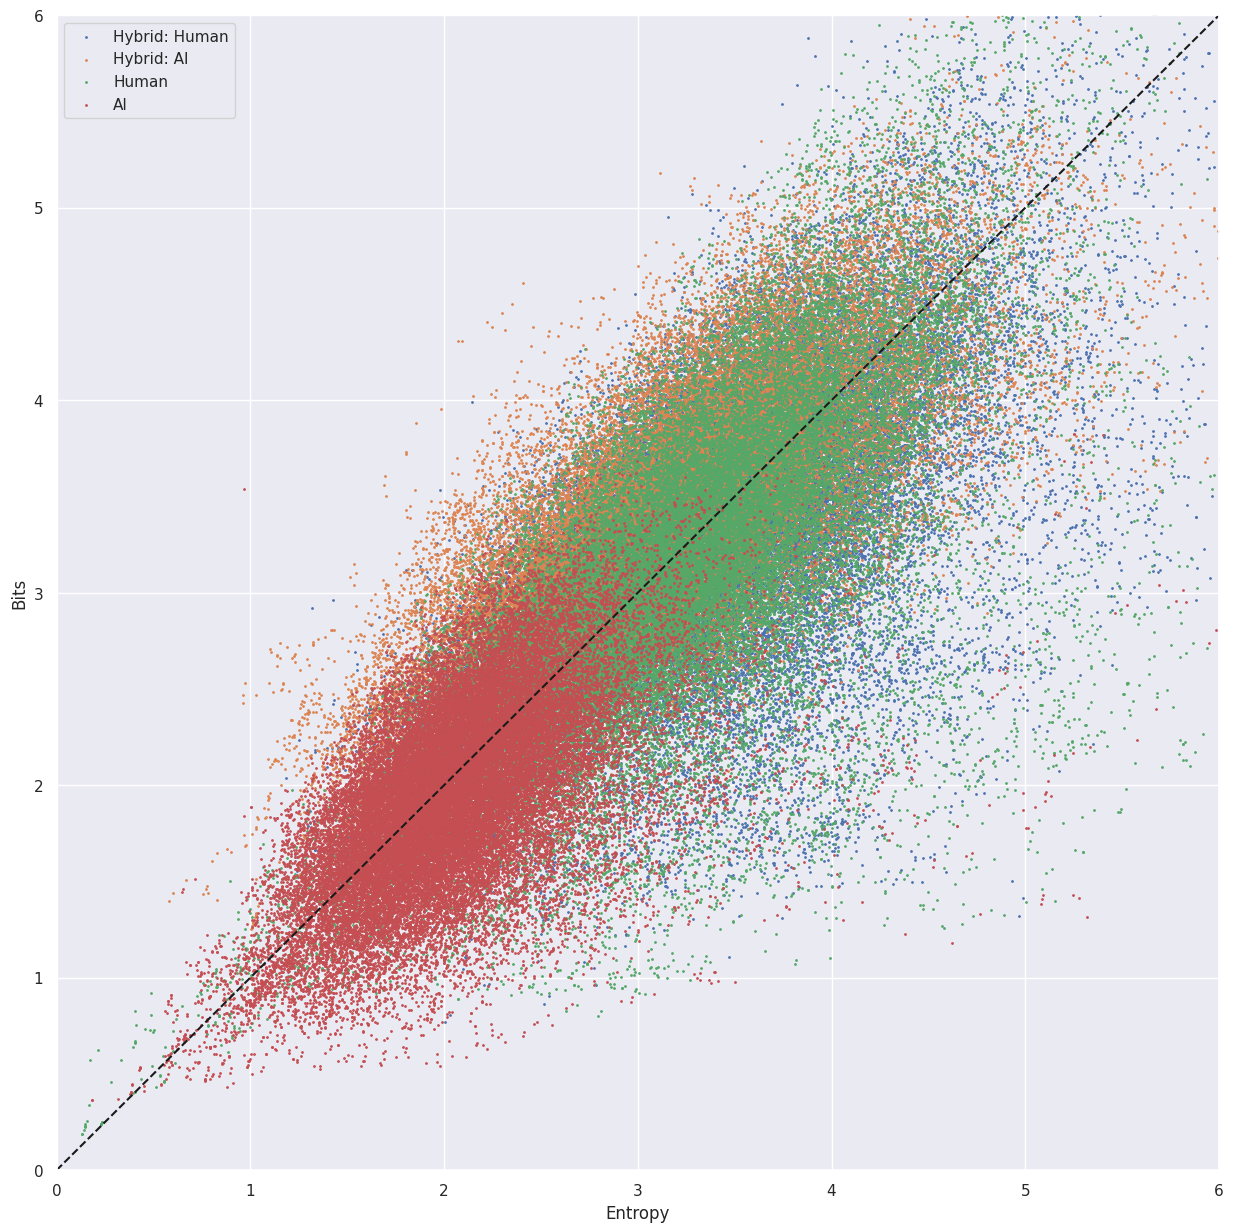

In [40]:
# all in one plot

plt.figure(figsize=(15, 15))

plt.scatter(hybrid_human[:, 0], hybrid_human[:, 1], s=1, label='Hybrid: Human')
plt.scatter(hybrid_AI[:, 0], hybrid_AI[:, 1], s=1, label='Hybrid: AI')
plt.scatter(human[:, 0], human[:, 1], s=1, label='Human')
plt.scatter(AI[:, 0], AI[:, 1], s=1, label='AI')

plt.plot(viewport, viewport, 'k--')
plt.xlabel('Entropy')
plt.ylabel('Bits')

plt.xlim(viewport)
plt.ylim(viewport)

plt.legend()
plt.show()

In [52]:
# circle plot to show mean and stdev
import plotly.graph_objects as go

fig = go.Figure()

def plot_circle(data, label, i, std_scale=0.25):
    mean = np.mean(data, axis=0)
    stdev = np.std(data, axis=0) * std_scale

    # fig.add_trace(go.Scatter(
    #     x=data[:, 0],
    #     y=data[:, 1],
    #     mode="markers",
    #     marker=dict(size=1),
    #     marker_color=fig.layout['template']['layout']['colorway'][i],
    #     name=label,
    # ))
    fig.add_trace(go.Scatter(
        x=[mean[0]],
        y=[mean[1]],
        mode="markers",
        marker=dict(size=10),
        marker_color=fig.layout['template']['layout']['colorway'][i],
        name=label,
    ))
    fig.add_shape(
        type="circle",
        xref="x",
        yref="y",
        x0=mean[0] - stdev[0],
        y0=mean[1] - stdev[1],
        x1=mean[0] + stdev[0],
        y1=mean[1] + stdev[1],
        line_color="LightSeaGreen",
    )

plot_circle(hybrid_human, 'Hybrid: Human', 0)
plot_circle(hybrid_AI, 'Hybrid: AI', 1)
plot_circle(human, 'Human', 2)
plot_circle(AI, 'AI', 3)
plot_circle(AI_with_human_help, 'AI with human help', 4)
plot_circle(completion_human, 'Completion: Human', 5)
plot_circle(completion_ai, 'Completion: AI', 6)

# line plot x=y
fig.add_trace(go.Scatter(
    x=[1.8,4],
    y=[1.8,3.8],
    mode="lines",
    line=dict(color="black", dash="dash"),
    name="y=x",
))

fig.update_layout(
    xaxis_title='Entropy',
    yaxis_title='Bits',
    showlegend=True,
    width=800,
    height=800,
)
fig.show()

In [ ]:
assert False # "Stop here"

In [42]:
X, Y, _ = get_data(features, masks, labels, kernels['boxcar'](20), data_size=1000000)

entropy = X[:, 0]
bits = X[:, 1]

ai_count = entropy[Y == 1].shape[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(entropy[Y == 0][:ai_count], bits[Y == 0]
                [:ai_count], s=0.1, alpha=0.03)
axes[1].scatter(entropy[Y == 1], bits[Y == 1], s=0.1, alpha=0.03)

for ax in axes:
    ax.plot((0, 10), (0, 10), c='r')
    ax.set_xlim(0, 6)
    ax.set_ylim(0, 6)
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Bits')

axes[0].set_title('Human')
axes[1].set_title('AI')

plt.show()

NameError: name 'features' is not defined

In [ ]:
np.sum(Y) / Y.shape[0]

In [ ]:
embed.shape

In [ ]:
embed_matrix = embed.detach().cpu().numpy()

In [ ]:
# pca
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(embed_matrix)

embed_pca = pca.transform(embed_matrix)
plt.scatter(embed_pca[:, 0], embed_pca[:, 1], s=0.1)

In [ ]:
embed_matrix.shape

In [ ]:
import re

raw_vocabs = tokenizer.get_vocab()

vocab = [''] * len(raw_vocabs)

en_indicies = []

for key, value in raw_vocabs.items():
    vocab[value] = key
    if re.match(r'^[a-zA-Z]+$', key):
        en_indicies.append(value)

In [ ]:
len(en_indicies) / len(vocab)

In [ ]:
def metrics(pred, true):
    accuracy = np.mean(pred == true)
    precision = np.sum(pred & true) / np.sum(pred)
    recall = np.sum(pred & true) / np.sum(true)
    f1 = 2 * precision * recall / (precision + recall)
    return accuracy, precision, recall, f1

#test metrics
pred = np.array([True, False, True, False, True, False, True, False, True, False])
true = np.array([True, False, False, False, True, False, True, False, True, False])

metrics(pred, true)

In [ ]:
# from collections import defaultdict
# from sklearn.svm import SVC
# from tqdm import tqdm

# smooth_factors = [
#     15, 20, 30, 45, 70, 100, 200, 350, 550, 700, 1000, 1200
# ]

# sigma = [
#     1, 2, 4, 8, 16, 32, 64, 128, 256
# ]

# beta = [
#     0.25, 0.5, 1, 2, 4, 8, 16, 32, 64
# ]

# kernel_strategies = {
#     'boxcar': boxcar_kernel,
#     'boxcar_left': boxcar_left_kernel,
#     'boxcar_right': boxcar_right_kernel,
#     'gaussian': gaussian_kernel,
#     'triangular': triangular_kernel,
#     'epanechnikov': epanechnikov_kernel,
#     'hamming': hamming_kernel,
#     'hanning': hanning_kernel,
#     'blackman': blackman_kernel,
#     'kaiser': kaiser_kernel,
#     'cosine': cosine_kernel,
#     'bartlett': bartlett_kernel,
# }

# svr_correctnesses = defaultdict(list)

# train_size = 5000
# test_size = 10000

# features = np.concatenate([cf, hf, gf, rf])
# labels = np.concatenate([cl, hl, gl, rl])
# masks = np.concatenate([cm, hm, gm, rm])


# for kernel_name, kernel in tqdm(kernel_strategies.items()):
#     for smooth_factor in smooth_factors:
#             svm_type = 'rbf'
#             kernel_args = [None]
#             if kernel_name == 'gaussian':
#                 kernel_args = sigma
#             if kernel_name == 'kaiser':
#                 kernel_args = beta

#             for arg in kernel_args:
#                 if arg == None:
#                     smooth_kernel = normalize(kernel(smooth_factor))
#                     name = kernel_name
#                 else:
#                     smooth_kernel = normalize(kernel(smooth_factor, arg))
#                     name = f'{kernel_name}_{arg}'

#                 X_train, Y_train = get_data(features, masks, labels, smooth_kernel=smooth_kernel, data_size=train_size)
#                 X_test, Y_test = get_data(features, masks, labels, smooth_kernel=smooth_kernel, data_size=test_size)

#                 svr = SVC(kernel=svm_type)
#                 svr.fit(X_train, Y_train)

#                 X_pred = svr.predict(X_test)
#                 correctness = metrics(X_pred, Y_test)

#                 svr_correctnesses[name].append(correctness)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC

kernel = kernels['triangular'](27)

train_size = 10000
test_size = 10000

X_train, Y_train, indicies = get_data(features, masks, labels, smooth_kernel=kernel, data_size=train_size)
X_test, Y_test, _ = get_data(features, masks, labels, smooth_kernel=kernel, data_size=test_size, indices=indicies)

svr = SVC(kernel='rbf', probability=True, C=1)

svr.fit(X_train, Y_train)

Y_probs = svr.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot(fpr, thresholds, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot(tpr, thresholds, color='darkblue', lw=2, label='Thresholds')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve')
plt.show()

In [ ]:
youden = tpr - fpr
youden_max = np.argmax(youden)

plt.plot(thresholds, youden)

print(thresholds[youden_max])

tests = [
    (cf, cl, cm, 'coauthor'),
    (hf, hl, hm, 'human'),
    (gf, gl, gm, 'generation'),
    # (rf, rl, rm, 'refinement'),
    (cpf, cpl, cpm, 'completion'),
    (features, labels, masks, 'all'),
]
results = {}

train_size = 5000
test_size = 5000

for feature, label, mask, name in tests:
    X_train, Y_train, indices = get_data(feature, mask, label, smooth_kernel=kernel, data_size=train_size)
    X_test, Y_test, _ = get_data(feature, mask, label, smooth_kernel=kernel, data_size=test_size, indices=indices)

    Y_probs = svr.predict_proba(X_test)[:, 1]
    Y_pred = Y_probs > thresholds[youden_max]

    print(np.mean(Y_pred))
    correctness = metrics(Y_pred, Y_test)
    results[name] = correctness

for key, item in results.items():
    print(key, item)

In [ ]:
def num_to_color(score):
    return f"hsl({(1 - score) * 120}, 100%, 50%)"

def write_color(text, num):
    return f"<span style='color: {num_to_color(num)};'>{text}</span>"

def save_as_markdown(essay, offset_mapping, predictions, f):
    for i in range(len(offset_mapping)):
        start = offset_mapping[i][0]
        end = offset_mapping[i][1]

        # Writing the colored part using inline HTML within Markdown
        p = predictions[i]

        colored_text = write_color(essay[start:end], p)
        f.write(colored_text)

        # Writing the non-colored part between this and the next segment
        if i < len(offset_mapping) - 1:
            f.write(essay[end:offset_mapping[i+1][0]])
        else:
            f.write(essay[end:])

def save_as_markdown_pre_mask(essay, mask, f):
    for i in range(len(mask)):
        if mask[i] == 'A':
            colored_text = write_color(essay[i], 1)
        else:
            colored_text = write_color(essay[i], 0)
        f.write(colored_text)

def save_comparsion_as_markdown(essay, offset_mapping, actual, predictions, file_name):
    with open(file_name, "w") as f:
        f.write("# Actual\n")
        save_as_markdown_pre_mask(essay, actual, f)
        f.write("\n\n# Predicted\n")
        save_as_markdown(essay, offset_mapping, predictions, f)

In [ ]:
def save_comparsion_data(data, index, name):
    text, label = data[index]
    feature, _, mask = process_data([data[index]])
    feature = smooth(feature, masks, kernel)[0]
    Y_probs = svr.predict_proba(features)[:, 1]
    Y_pred = Y_probs > thresholds[youden_max]
    # Y_probs = (Y_probs - 0.23) / (0.4) + 0.5
    # Y_probs = np.clip(Y_probs, 0, 1)
    offset_mapping = tokenizer(text, return_offsets_mapping=True, max_length=1200, truncation=True).offset_mapping
    save_comparsion_as_markdown(text, offset_mapping, label, Y_pred, f"{name}_{index}.md")

In [ ]:
index = 5

coauthor_raw = load_coauthor_raw(10)
coauthor_data = list(map(extract_text_and_mask, coauthor_raw))

save_comparsion_data(coauthor_data, index, "coauthor")

In [ ]:
with open("dataset_creation/human_dataset.json", "r") as f:
    generation_data = json.load(f)
    generation_data = list(map(lambda x: x["article"], generation_data))

generation_data = generation_data[:load_data_length]
generation_data = list(map(lambda x: (x, "H" * len(x)), generation_data))

index = 23

save_comparsion_data(generation_data, index, "generation")

In [ ]:
with open(f'{path}.txt', 'r') as f:
    text = f.read()
features, _, masks = process_data([(text, "A" * len(text))])

features = smooth(features, masks, kernel)[0]
Y_probs = svr.predict_proba(features)[:, 1]
# print(Y_probs)
Y_pred = Y_probs > thresholds[youden_max]

# Y_probs = (Y_probs - 0.23) / (0.4) + 0.5
# Y_probs = np.clip(Y_probs, 0, 1)

offset_mapping = tokenizer(text, return_offsets_mapping=True, max_length=1200, truncation=True).offset_mapping
save_as_markdown(text, offset_mapping, Y_probs, f'{path}_pred')

In [ ]:
# #export model
# from joblib import dump

# dump(svr, 'model.joblib')

In [ ]:


labels = np.concatenate([cl, hl, gl, rl, cpl])
masks = np.concatenate([cm, hm, gm, rm, cpm])
features = np.concatenate([cf, hf, gf, rf, cpf])

smooth_features = smooth(features, masks, kernel)
smooth_features = smooth_features[masks[:, :, 0] == 1]

labels = labels[masks == 1]
labels = labels > 0.5

indicies = np.random.choice(smooth_features.shape[0], 30000, replace=False)
smooth_features = smooth_features[indicies]
labels = labels[indicies]

#convert to 0 and 1
labels = labels.astype(int)

In [ ]:
# plot

fig, ax = plt.subplots(3, 2, figsize=(10, 15))

names = ['entropy', 'similarity', 'bits', 'stdev']
combinations = [
    (0, 1), (0, 2), (0, 3),
    (1, 2), (1, 3),
    (2, 3)
]

for i, (x, y) in enumerate(combinations):
    ax[i // 2, i % 2].scatter(smooth_features[:, x], smooth_features[:, y], c=labels, s=0.3)
    ax[i // 2, i % 2].set_xlabel(names[x])
    ax[i // 2, i % 2].set_ylabel(names[y])


In [ ]:
# Assuming smooth_factors and svr_correctnesses are defined somewhere in your code
# Example:
# smooth_factors = np.linspace(0, 1, 100)
# svr_correctnesses = {'model1': [[acc1, prec1, rec1, f11], ...], 'model2': [...], ...}

fig, axes = plt.subplots(5, 6, figsize=(30, 30))

# Define a color map for the four metrics
colors = ['blue', 'green', 'red', 'black']  # for example, accuracy, precision, recall, f1

for i, (name, correctnesses) in enumerate(svr_correctnesses.items()):
    row = i // 6
    col = i % 6
    ax = axes[row, col]
    ax.set_title(name)

    correctnesses = np.array(correctnesses)

    accuracy = correctnesses[:, 0]
    precision = correctnesses[:, 1]
    recall = correctnesses[:, 2]
    f1 = correctnesses[:, 3]

    # Use the colors defined above for each metric
    ax.plot(smooth_factors, accuracy, label='accuracy', color=colors[0])
    ax.plot(smooth_factors, precision, label='precision', color=colors[1])
    ax.plot(smooth_factors, recall, label='recall', color=colors[2])
    ax.plot(smooth_factors, f1, label='f1', color=colors[3])

    ax.set_ylim(0.65, 1.0)
    # log scale for x axis
    ax.set_xscale('log')

    ax.set_xlabel('kernel size')
    ax.set_ylabel('scores')

# Set the labels for the first subplot only to avoid cluttering, they are the same for all anyway
axes[0, 0].legend()
# add gloabl titl
# add some space between subplots
fig.tight_layout()
plt.show()